In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns

from numpy.random import dirichlet
from scipy.stats import spearmanr, pearsonr
from torch.nn.functional import softmax

sns.set_theme(font="serif")

In [15]:
# parameters
alpha = 0.1
domain_size = 1000
scaling = 42
noise = 0.042
seed = 42

# sampling
num_corpora = 1000
num_per_corpus = 100_000

# typicality
epsilon = 0.00005

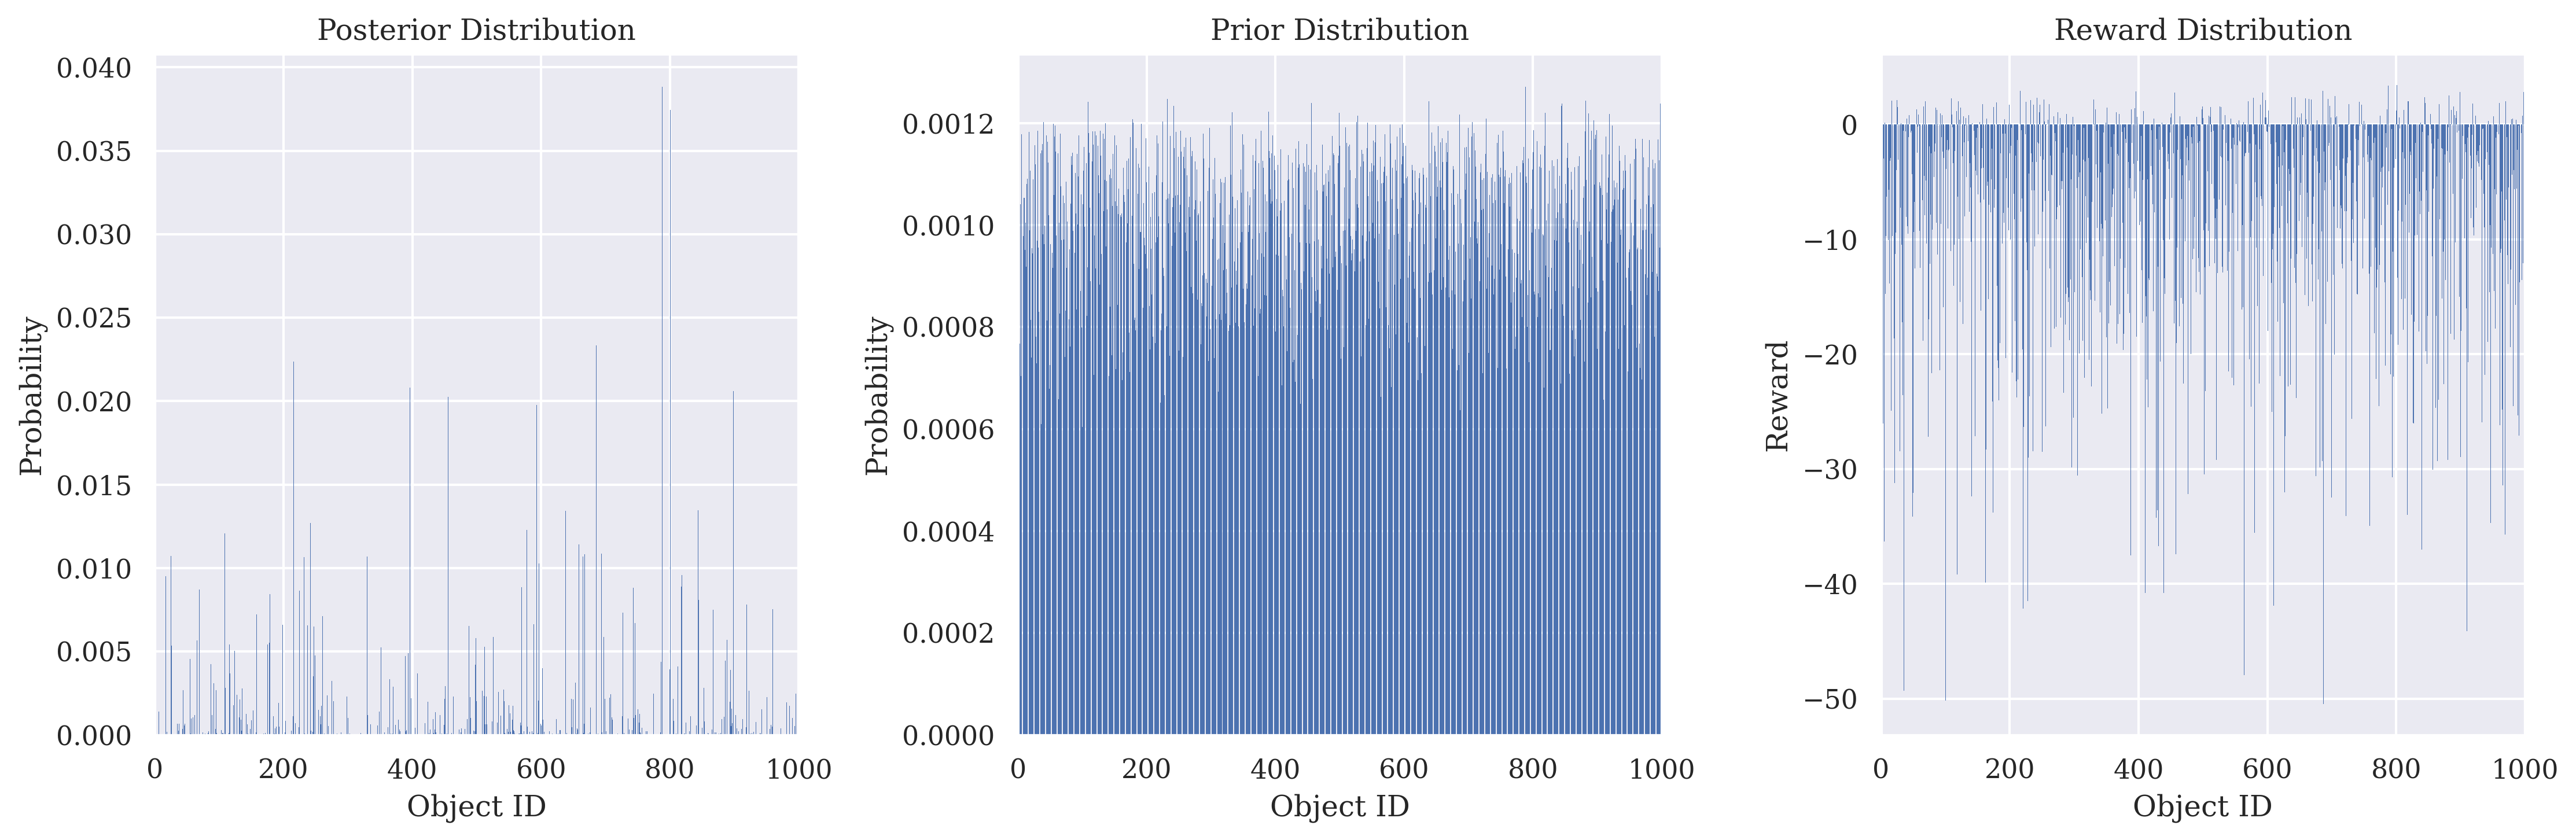

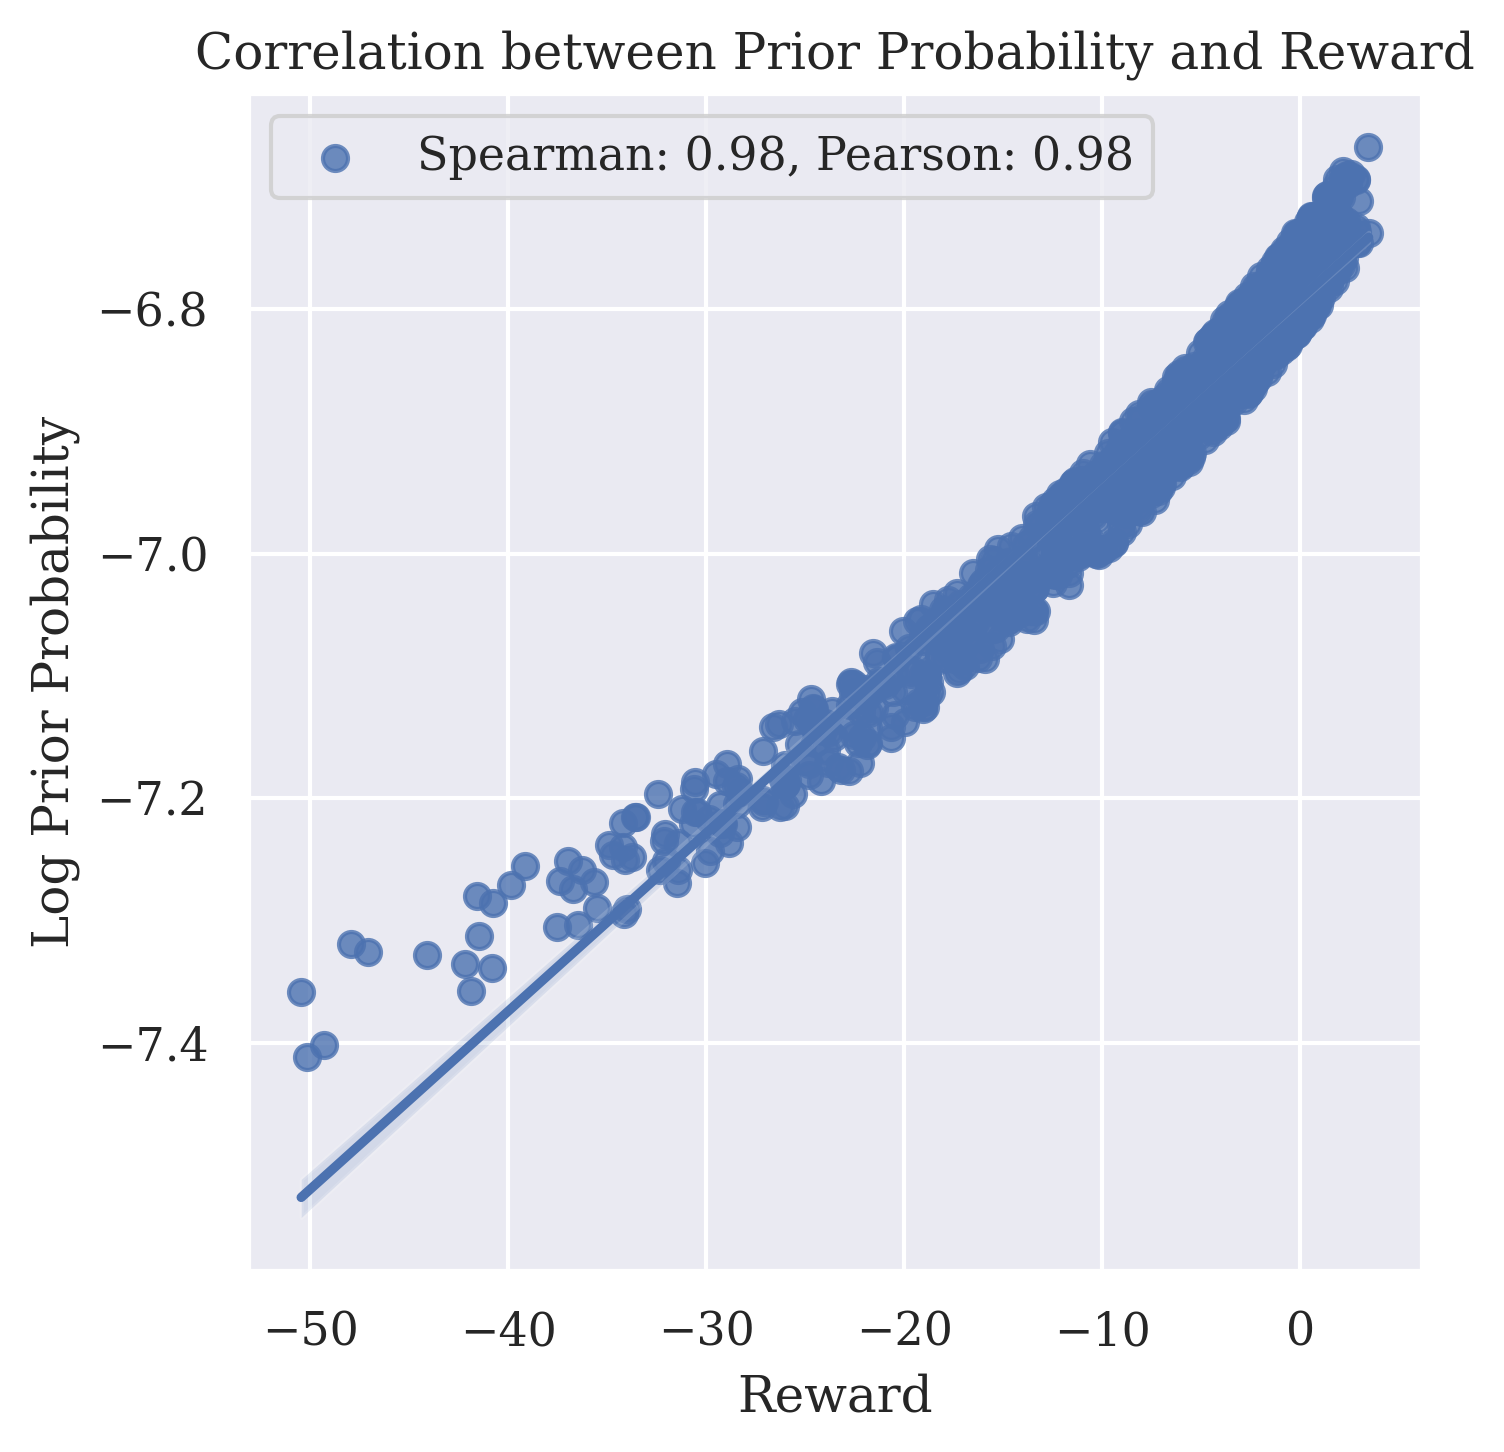

In [16]:
# 1. create p(y|A=+), p(y) and r(y), such that p(y) and r(y) are correlated
np.random.seed(seed)
p_y_A = dirichlet(alpha=[alpha] * domain_size, size=1).flatten()
p_y = softmax(
    torch.from_numpy(p_y_A) ** (1 / scaling)
    + np.random.uniform(-noise, noise, size=domain_size),
    dim=0,
).numpy()
reward = np.log(p_y_A / p_y)
assert np.allclose(np.sum(p_y_A), 1)
assert np.allclose(np.sum(p_y), 1)

# 1.1 plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
ax[0].bar(range(domain_size), p_y_A, edgecolor="none")
ax[0].set_title("Posterior Distribution")
ax[0].set_ylabel("Probability")

ax[1].bar(range(domain_size), p_y, edgecolor="none")
ax[1].set_title("Prior Distribution")
ax[1].set_ylabel("Probability")


ax[2].bar(range(domain_size), reward, edgecolor="none")
ax[2].set_title("Reward Distribution")
ax[2].set_ylabel("Reward")

for a in ax:
    a.set_xlabel("Object ID")
    a.set_xlim(0, domain_size)

plt.tight_layout()
plt.show()
plt.close()

# 2. plot correlation between log p(y) and r(y)
fig = plt.figure(figsize=(5, 5), dpi=300)
log_p_y = np.log(p_y)
spearman = spearmanr(log_p_y, reward)[0]
pearson = pearsonr(log_p_y, reward)[0]
plt.title("Correlation between Prior Probability and Reward")
sns.regplot(
    data=pd.DataFrame({"log_p_y": log_p_y, "reward": reward}),
    y="log_p_y",
    x="reward",
    label=f"Spearman: {spearman:.2f}, Pearson: {pearson:.2f}",
)
plt.ylabel("Log Prior Probability")
plt.xlabel("Reward")

plt.legend()
plt.tight_layout()
plt.show()
plt.close()

Joint Entropy: 5.01


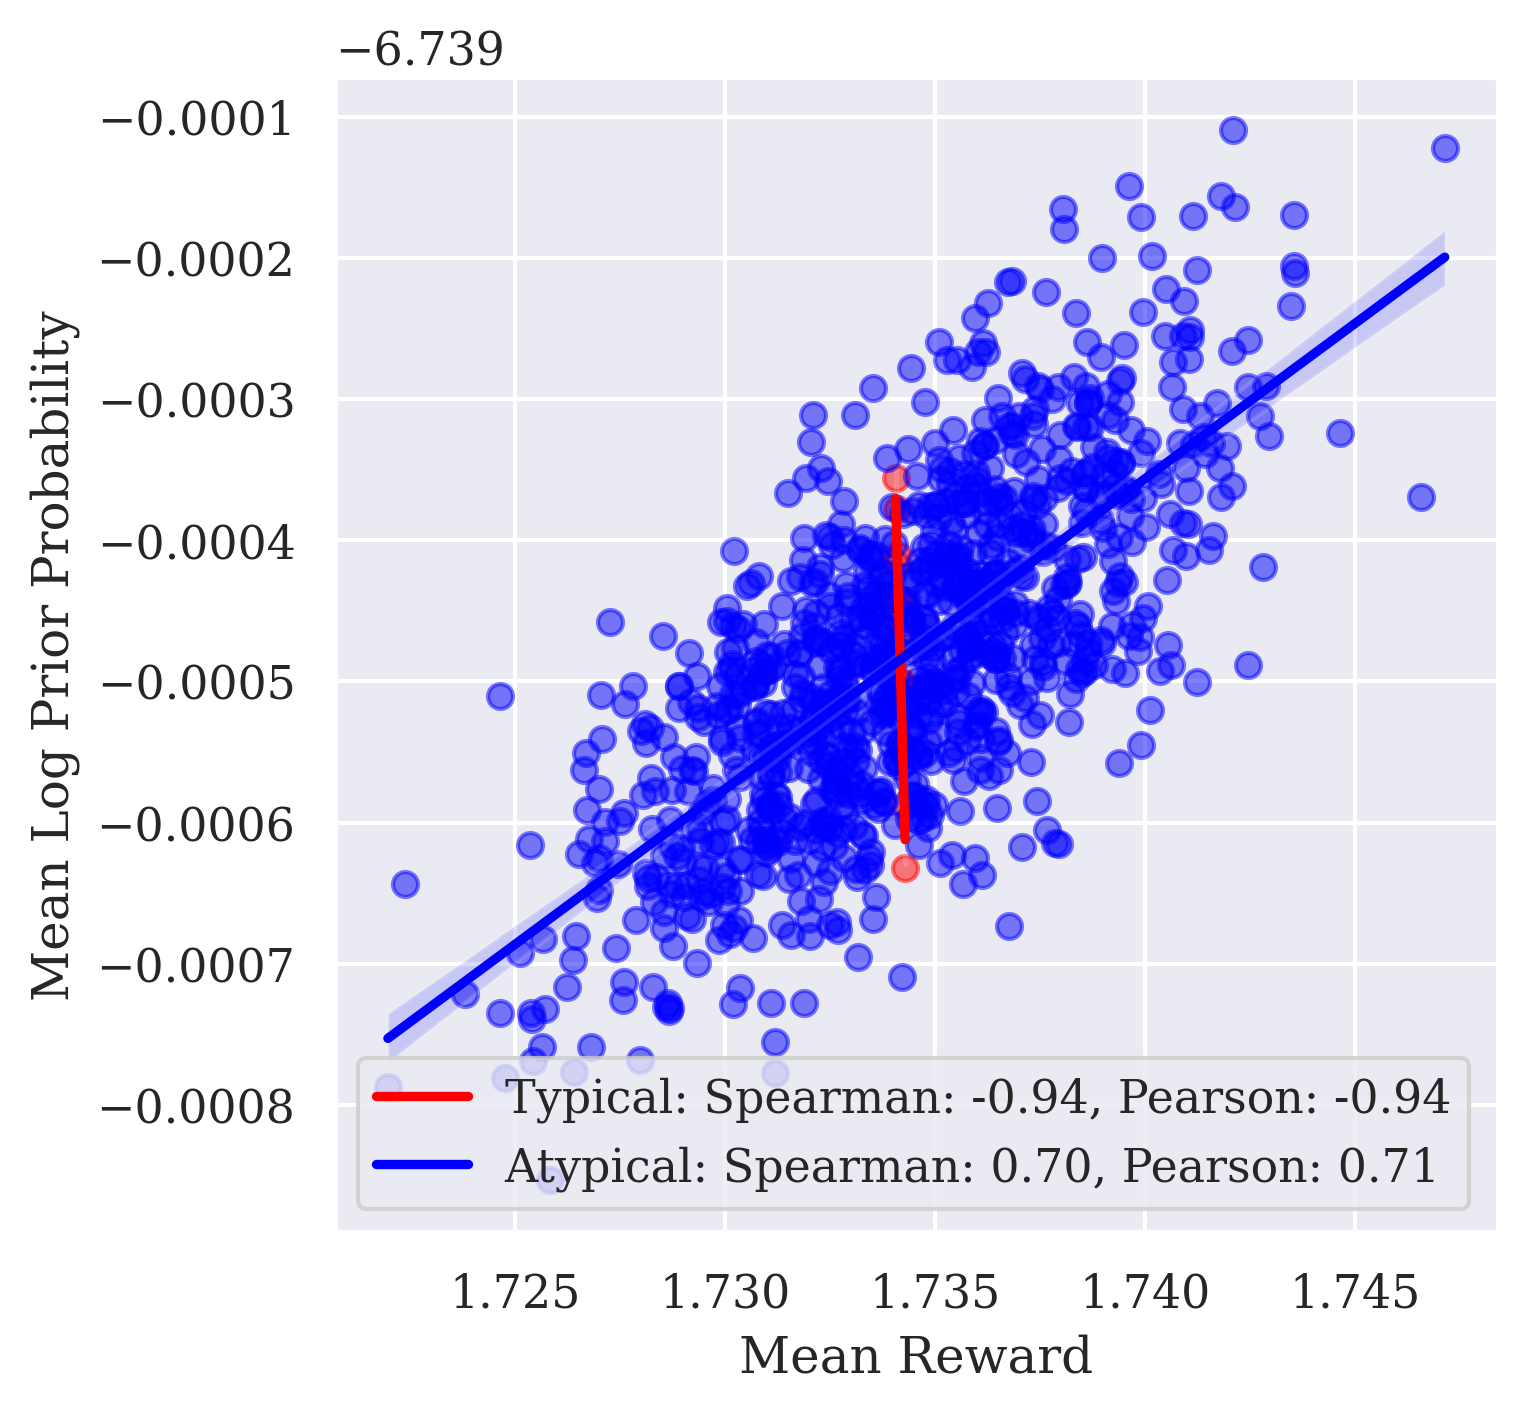

In [17]:
# 3. compute entropy
entropy = -np.sum(p_y_A * np.log(p_y_A))
print(f"Joint Entropy: {entropy:.2f}")

# 4. sample corpora from p(y|A=+)
typical_corpora = []
atypical_corpora = []
for corpus_id in range(num_corpora):
    corpus = np.random.choice(range(domain_size), size=num_per_corpus, p=p_y_A)
    sample_p_y_A = np.array([p_y_A[i] for i in corpus])
    sample_p_y = np.array([p_y[i] for i in corpus])
    sample_reward = np.array([reward[i] for i in corpus])

    # 4.1 check for typicality
    sample_entropy = -np.mean(np.log(sample_p_y_A))
    is_typical = np.abs(entropy - sample_entropy) < epsilon
    # print(f"Corpus {corpus_id}: Typical={is_typical}, Entropy={sample_entropy:.2f}")

    if is_typical:
        typical_corpora.append((sample_p_y, sample_reward, sample_p_y_A))
    else:
        atypical_corpora.append((sample_p_y, sample_reward, sample_p_y_A))

# 5. plot typical and atypical corpora
fig = plt.figure(figsize=(5, 5), dpi=300)
for corpora_set, corpora_set_label in [
    (typical_corpora, ("Typical", "red")),
    (atypical_corpora, ("Atypical", "blue")),
]:
    corpora_set_name, corpora_set_color = corpora_set_label

    # 5.1 scatter plot
    mean_rewards = []
    mean_log_p_ys = []
    for sample_p_y, sample_reward, sample_p_y_A in corpora_set:
        mean_reward = np.mean(sample_reward)
        mean_log_p_y = np.mean(np.log(sample_p_y))
        plt.scatter(mean_reward, mean_log_p_y, color=corpora_set_color, alpha=0.5)

        # append to track
        mean_rewards.append(mean_reward)
        mean_log_p_ys.append(mean_log_p_y)
    # 5.2 compute
    spearman = spearmanr(mean_rewards, mean_log_p_ys)[0]
    pearson = pearsonr(mean_rewards, mean_log_p_ys)[0]
    sns.regplot(
        data=pd.DataFrame({"mean_reward": mean_rewards, "mean_log_p_y": mean_log_p_ys}),
        y="mean_log_p_y",
        x="mean_reward",
        label=f"{corpora_set_name}: Spearman: {spearman:.2f}, Pearson: {pearson:.2f}",
        color=corpora_set_color,
        scatter=False,
    )

plt.legend()
plt.xlabel("Mean Reward")
plt.ylabel("Mean Log Prior Probability")
plt.show()
plt.close()